<a href="https://colab.research.google.com/github/sharon-raj-1718/CE888/blob/main/PROJECT_2/ASSIGNMENT_1/OFFENSIVE/TweetEval_offensive_ce888.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                  **TweetEval-based Multi-class tweet classification**









# Loading of libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import re
import requests
import string
from nltk.corpus import stopwords
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm
from wordcloud import WordCloud


# Load the dataset

In [ ]:

train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt",encoding='utf-8',sep="\t", header=None)
train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt",encoding='utf-8',sep="\t", header=None)
validate_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt",encoding='utf-8',sep="\t", header=None)
validate_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt",encoding='utf-8',sep="\t", header=None)
test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt",encoding='utf-8',sep="\t", header=None)
test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt",encoding='utf-8',sep="\t", header=None)
map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt",encoding='utf-8',sep="\t", header=None)



In [ ]:
train_text.columns= ["text"]
train_label.columns= ["label"]
validate_text.columns= ["text"]
validate_label.columns= ["label"]
test_text.columns= ["text"]
test_label.columns= ["label"]
map.columns= ["label","off"]

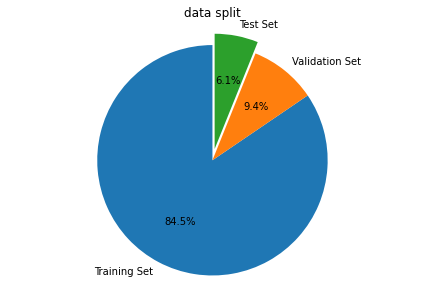

In [ ]:
labels = ['Training Set', 'Validation Set', 'Test Set'] 
sizes = [len(train_label), len(validate_label), len(test_label)] 
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.tight_layout() 
plt.title("data split") 
plt.show()

# Preprocessing

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


#Pulls Out all the HTML related tags ,unwanted characters and Amend text to lowercase

In [ ]:
def clean_tweet(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = text.strip().lower()
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    return text

# Tokenizing function used for all the data

In [ ]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_tweet(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

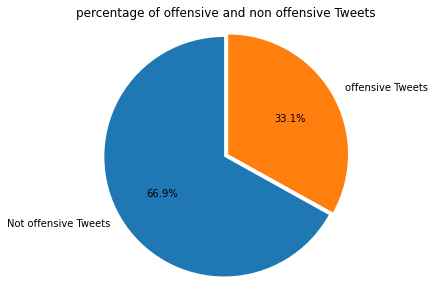

In [ ]:
non_off = train_label[train_label.label == 0].shape[0]
off = train_label[train_label.label == 1].shape[0]

labels = ['Not offensive Tweets', ' offensive Tweets']
sizes = [non_off, off]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("percentage of offensive and non offensive Tweets")
plt.show()

#sucession the  dataframe and some further preprocessing

In [ ]:

con_train = pd.concat([train_text,train_label], axis=1)
con_val = pd.concat([validate_text,validate_label], axis=1)
con_test = pd.concat([test_text,test_label], axis=1)

off_train = pd.merge(con_train,map, on='label')
off_validate = pd.merge(con_val,map, on='label')
off_test = pd.merge(con_test,map, on='label')

train_validate = pd.concat([off_train,off_validate])

off_train1 = train_validate.copy()
off_train1['clean_t'] = off_train1['text'].apply(str).apply(lambda x: text_preprocessing(x))
off_train1['clean_t'] = off_train1['clean_t'].str.replace('user','')
off_train1['clean_t'] = off_train1['clean_t'].str.replace('amp','')
off_train1



,text,label,off,clean_t
0,@user Bono... who cares. Soon people will unde...,0,not-offensive,bono who cares soon people will understand th...
1,@user Get him some line help. He is gonna be j...,0,not-offensive,get him some line help he is gonna be just fi...
2,@user @user She is great. Hi Fiona!,0,not-offensive,she is great hi fiona
3,@user @user @user @user @user @user @user @use...,0,not-offensive,this is the vetsresistsquadron ...
4,@user @user Lol. Except he’s the most successf...,0,not-offensive,lol except he s the most successful presiden...
...,...,...,...,...
1319,@user @user @user Weak argument considering -...,1,offensive,weak argument considering gop congressmen w...
1320,@user Stop saying this shit you are not going ...,1,offensive,stop saying this shit you are not going to do...
1321,@user @user @user @user @user Sorry to break i...,1,offensive,sorry to break it to you but the god of t...
1322,. she. is the most powerful woman on this eart...,1,offensive,she is the most powerful woman on this earth o...


In [ ]:

off_1 = off_train1[off_train1 ['off'] == 'off']['clean_t']
off_0 = off_train1[off_train1 ['off'] == 'non-off']['clean_t'] 


# Vectorizing for Offensive dataset

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english",preprocessor=clean_tweet,ngram_range=(1, 4))
training_features = vectorizer.fit_transform(train_validate["text"])    
test_features = vectorizer.transform(off_test["text"])  


# Training the model

In [ ]:
model = LinearSVC()
model.fit(training_features, train_validate["off"])
y_pred = model.predict(test_features)

# Evaluation metrics

In [ ]:
score = f1_score(off_test["off"], y_pred,average='macro')

print("Accuracy for the offensive: {:.2f}".format(score*100,2))

Accuracy for the offensive: 74.88
